In [2]:
from sklearn.datasets import fetch_openml

wine_reviews = fetch_openml(data_id=42074, as_frame=True)

df = wine_reviews.frame
df.head()

c:\Users\danyb\miniconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,None,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,None,Provence red blend,Domaine de la Bégude


our target is the column points.

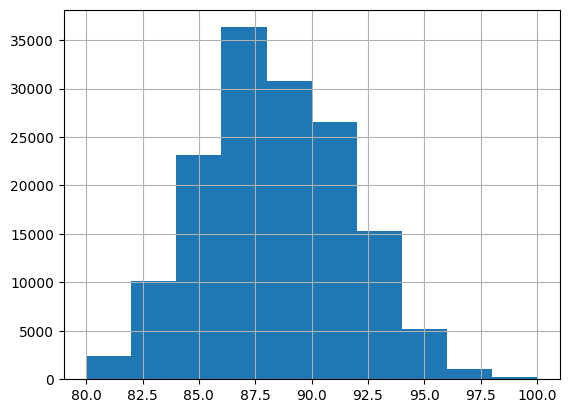

In [3]:
numerical_features = ["price"]
categorical_features = [
    "country",
    "province",
    "region_1",
    "region_2",
    "variety",
    "winery",
]
target_name = "points"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

We will use histGradientBoostingRegressor to predict the points, and test different enconding for the categorical features.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder#, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    # ("target", TargetEncoder(target_type="continuous")), local error with this encoder
]

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

n_cv_folds = 3
max_iter = 20
results = []


def evaluate_model_and_store(name, pipe):
    result = cross_validate(
        pipe,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=n_cv_folds,
        return_train_score=True,
    )
    rmse_test_score = -result["test_score"]
    rmse_train_score = -result["train_score"]
    results.append(
        {
            "preprocessor": name,
            "rmse_test_mean": rmse_test_score.mean(),
            "rmse_test_std": rmse_train_score.std(),
            "rmse_train_mean": rmse_train_score.mean(),
            "rmse_train_std": rmse_train_score.std(),
        }
    )


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )x
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
    )
    evaluate_model_and_store(name, pipe)

visualization


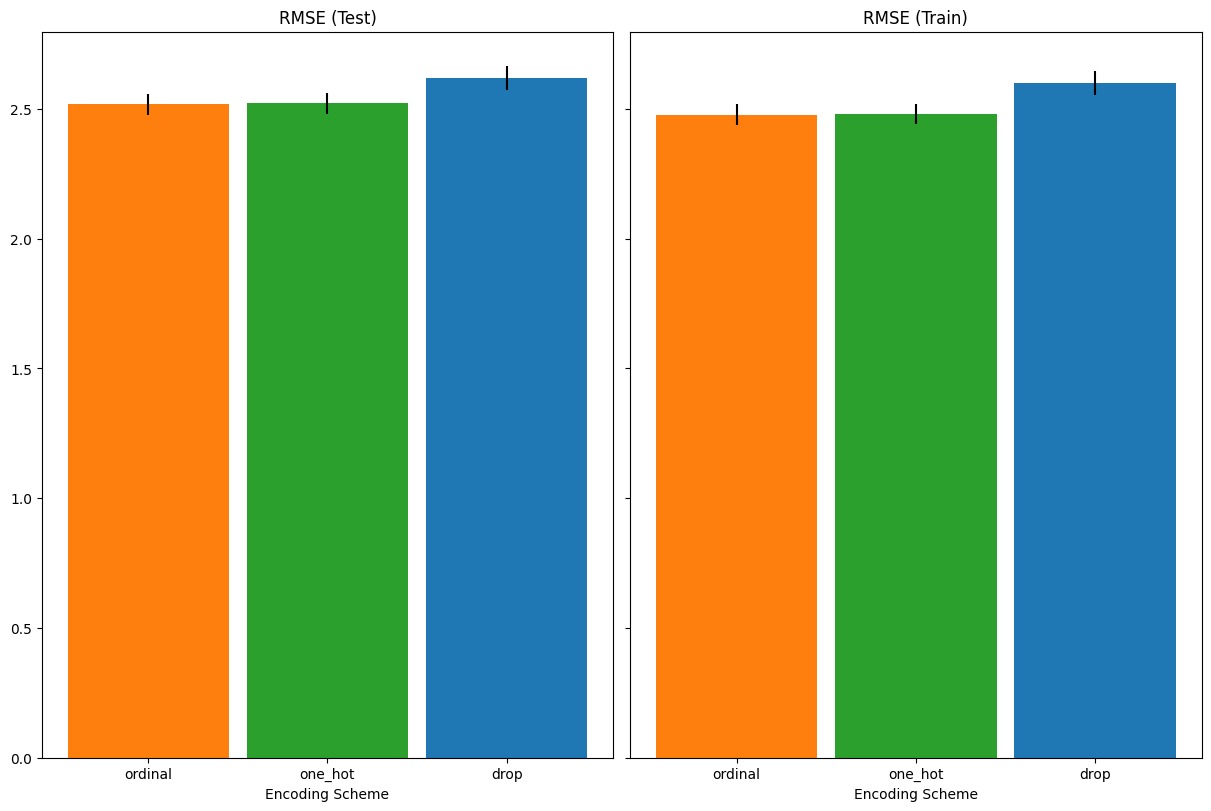

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = (
    pd.DataFrame(results).set_index("preprocessor").sort_values("rmse_test_mean")
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, constrained_layout=True
)
xticks = range(len(results_df))
name_to_color = dict(
    zip((r["preprocessor"] for r in results), ["C0", "C1", "C2", "C3", "C4"])
)

for subset, ax in zip(["test", "train"], [ax1, ax2]):
    mean, std = f"rmse_{subset}_mean", f"rmse_{subset}_std"
    data = results_df[[mean, std]].sort_values(mean)
    ax.bar(
        x=xticks,
        height=data[mean],
        yerr=data[std],
        width=0.9,
        color=[name_to_color[name] for name in data.index],
    )
    ax.set(
        title=f"RMSE ({subset.title()})",
        xlabel="Encoding Scheme",
        xticks=xticks,
        xticklabels=data.index,
    )

When assessing the predictive performance on the test set, the worst performance is observed when categories are dropped. This can be explained as follows:

- Dropping the categorical features reduces the expressiveness of the pipeline, leading to underfitting.

- The one-hot encoding scheme, used to manage high cardinality and reduce training time, is set to `max_categories=20` to prevent excessive feature expansion, which could also lead to underfitting.

- If `max_categories=20` was not set, the one-hot encoding scheme could potentially cause overfitting due to the explosion of features with rare category occurrences that are correlated with the target by chance (only on the training set).

- The ordinal encoding assigns an arbitrary order to the features, which are then treated as numerical values by the `HistGradientBoostingRegressor`. As this model groups numerical features into 256 bins per feature, many unrelated categories may be grouped together, causing the overall pipeline to underfit.

